# Non-constant Hessian - 2D Mixture of Gaussians

### Imports

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import Hug, HugTangential, NoAR
from utils import quick_3d_scatter, quick_3d_scatters
import plotly.graph_objects as go

### Mixture Settings

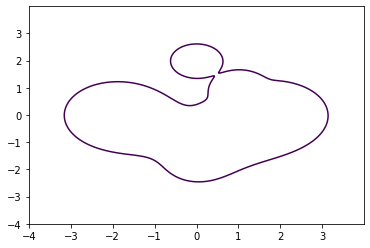

In [2]:
### Parameters of Mixture
# Means
mus = np.array([
    [0, 0],
    [2, 0],
    [0, 2],
    [-2, 0],
    [0, -2],
    [1, 1]
])
# Covariances
Sigmas = np.stack([
    3.0 * np.eye(2),
    1.0 * np.eye(2),
    0.05 * np.eye(2),
    0.5 * np.eye(2),
    2.0 * np.eye(2),
    0.05 * np.eye(2)
])
# Mixture coefficients are all the same
d = mus.shape[0]
coefs = np.repeat(1/d, d)

# Gaussian Components
distributions = [multivariate_normal(mu, Sigma) for (mu, Sigma) in zip(mus, Sigmas)]

# Mixture, log mixture, grad of log mixture
MG = lambda xy: np.sum(np.vstack([c * MVN.pdf(xy)  for (c, MVN) in zip(coefs, distributions)]), axis=0)
logpi = lambda xy: np.log(MG(xy))
grad_log_pi = lambda xy: (1 / MG(xy)) * np.sum(np.vstack([- c * multivariate_normal(mu, Sigma).pdf(xy) * solve(Sigma, xy - mu) for (c, mu, Sigma) in zip(coefs, mus, Sigmas)]), axis=0)

# Find an odd contour
z = 0.016   # Sharp Turn: 0.016, Softer Turn: 0.004
plt.contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
plt.show()

### Starting Point

In [3]:
# Find starting point on contour
starting_guess = np.array([0.0, -2.5]) # Near Hook: np.array([-0.1, 2.5])
x0 = fsolve(lambda xy: np.append(MG(xy) - z, 0), starting_guess)

### Algorithm Settings

In [4]:
T = 1.0
B = 5
n = 10000
alpha = 0.99
beta = 1.0     # beta thug 0.5 #beta_thug * (1 - alpha) #0.05

### Hug and Tangential Hug Sampling

In [5]:
# Proposal distributions
q = multivariate_normal(np.zeros(2), beta * np.eye(2))

In [6]:
tsamples, tacc = HugTangential(x0, T, B, n, alpha, q, logpi, grad_log_pi)

In [7]:
hsamples, hacc = Hug(x0, T, B, n, q, logpi, grad_log_pi)

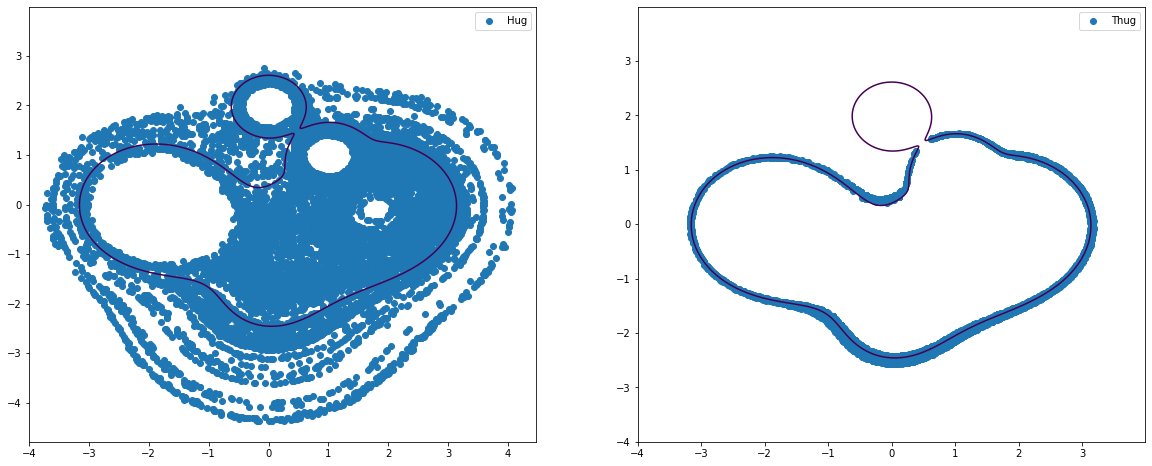

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
ax[0].scatter(*hsamples.T, label="Hug")
ax[0].legend()
ax[1].contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
ax[1].scatter(*tsamples.T, label="Thug")
ax[1].legend()
plt.show()

In [9]:
print("Acceptance Probability of Hug: {:.3}%".format(np.sum(hacc) * 100 / n))
print("Acceptance Probability of THug: {:.3}%".format(np.sum(tacc) * 100 / n))

Acceptance Probability of Hug: 99.2%
Acceptance Probability of THug: 71.8%


### Perfect Sampling

In [124]:
MGM = Manifold(m=1, d=1)
MGM.q = lambda xy: MG(xy) - z
MGM.Q = lambda xy: np.sum(np.vstack([- c * multivariate_normal(mu, Sigma).pdf(xy) * solve(Sigma, xy - mu) for (c, mu, Sigma) in zip(coefs, mus, Sigmas)]), axis=0).reshape(-1, 1)
logf = lambda xy: 0.0
logp = lambda xy: logp_scale(xy, sigma=1.0)
tol = 1.48e-08  
a_guess = np.array([0])
samples_zappa = zappa_sampling(x0, MGM, logf, logp, 1000, 1.0, tol, a_guess)

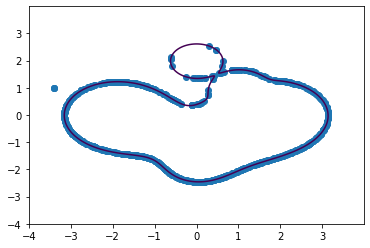

In [129]:
plt.scatter(*samples_zappa.T)
plt.contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
plt.show()